In [2]:
import numpy as np
import pandas as pd
import glob


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline


rc = {'axes.facecolor': '#E3DCD1',
      'font.family': 'Lucida Sans Unicode',
      'grid.linestyle': '-',
      'grid.linewidth': '0.75',
      'grid.color': '#ffffff',
      'mathtext.fontset': 'stixsans',
      'mathtext.sf': 'sans',
      'legend.frameon': True}
plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('mathtext', fontset='stixsans', sf='sans')
sns.set_style('darkgrid', rc=rc)
sns.set_palette("colorblind", color_codes=True)
sns.set(rc=rc)


## Outline for notebook

In this notebook we'll consider cell volume as a function of copy number. Note that the values reported in Schmidt et al. 2015 were measured by flow cytometry and come from Volkmer, B. & Heinemann, M. 2011. In discussions with RP and Ron Milo, there are potentially issues with those values. In more recent work using super-resolution microscopy volumes were measured somewhat more direction (also from Heinemann; Radziikoski et al. 2017). From Suckjoon Jun's lab, there are some additional cell volumes reported ( Taheri-Araghi, ..., Suckjoon Jun 2015).

## Load in data

In [13]:
# load in cell volumes reported
df_grow = pd.read_csv('../../../data/schmidt2016_raw_data/schmidt2016_growth_rates.csv')
df_grow = df_grow[df_grow.strain=='BW25113']

# vol_dict = pd.Series(df_grow['volume_fL'].values,index=df_grow['condition'].values).to_dict()

In [14]:
# load in Schmidt data
# combined_df = pd.read_csv('../../../data/combined_copynumbers_Schmidt_Li_Tanguichi.csv')
combined_df = pd.read_csv('../../../data/compiled_absolute_measurements.csv')
combined_df = combined_df[combined_df.dataset == 'schmidt_2016']
# combined_df = combined_df[combined_df.dataset == 'Schmidt']
# combined_df = combined_df.replace({'Glucose': 'glucose',
#  'LB': 'lb_miller',
#  'Glycerol + AA': 'glycerol_pAA',
#  'Acetate': 'acetate',
#  'Fumarate': 'fumarate',
#  'Glucosamine': 'glucosamine',
#  'Glycerol': 'glycerol',
#  'Pyruvate': 'pyruvate',
#  'Chemostat µ=0.5': 'chemostat_u0.5',
#  'Chemostat µ=0.35': 'chemostat_u0.35',
#  'Chemostat µ=0.20': 'chemostat_u0.2',
#  'Chemostat µ=0.12': 'chemostat_u0.12',
#  'stationary_1day': 'stationary_1day',
#  'stationary_3day': 'stationary_3day',
#  'Osmotic-stress glucose': 'osmotic_stress_glucose',
#  '42°C glucose': '42C',
#  'pH6 glucose': 'pH6',
#  'Xylose': 'xylose',
#  'Mannose': 'mannose',
#  'Galactose': 'galactose',
#  'Succinate': 'succinate',
#  'Fructose': 'fructose'})
combined_df.head()

,gene_name,b_number,condition,go_terms,cog_class,cog_category,cog_letter,growth_rate_hr,gene_product,tot_per_cell,fg_per_cell,dataset,dataset_name,strain
0,InsH-1,b0259,lb_miller,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,1.90,CP4-6 prophage; IS5 transposase and trans-acti...,376.512099,0.024580,schmidt_2016,Schmidt et al. 2016,BW25113
1,InsH-1,b0259,glycerol_pAA,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,1.27,CP4-6 prophage; IS5 transposase and trans-acti...,150.630122,0.009834,schmidt_2016,Schmidt et al. 2016,BW25113
2,InsH-1,b0259,acetate,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,0.30,CP4-6 prophage; IS5 transposase and trans-acti...,18.205011,0.001188,schmidt_2016,Schmidt et al. 2016,BW25113
3,InsH-1,b0259,fumarate,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,0.42,CP4-6 prophage; IS5 transposase and trans-acti...,59.163413,0.003862,schmidt_2016,Schmidt et al. 2016,BW25113
4,InsH-1,b0259,galactose,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,0.26,CP4-6 prophage; IS5 transposase and trans-acti...,38.830065,0.002535,schmidt_2016,Schmidt et al. 2016,BW25113


In [15]:
# for gene,data in combined_df.groupby(['gene_name', 'condition']):
#         data_list = {'cog_class' : data['cog_class'].values[0],
#                'cog_category' : data['cog_category'].values[0],
#                 'gene_name' : data.gene_name.values[0],
#                 'condition' :  data.condition.values[0],
#                 'tot_per_cell' : data.tot_per_cell.values[0],
#                 'dataset' : data.dataset.values[0],
#                     'volume_fL' : df_grow[df_grow.condition==gene[1]].volume_fL.values[0]}
#         combined_df = combined_df.append(data_list, ignore_index=True)

In [20]:
combined_df.condition.unique()

array(['lb_miller', 'glycerol_pAA', '42C', 'fructose', 'pH6', 'glucose',
       'osmotic_stress_glucose', 'xylose', 'chemostat_u0.5', 'mannose',
       'glycerol', 'glucosamine', 'succinate', 'fumarate', 'pyruvate',
       'chemostat_u0.35', 'acetate', 'galactose', 'chemostat_u0.2',
       'chemostat_u0.12'], dtype=object)

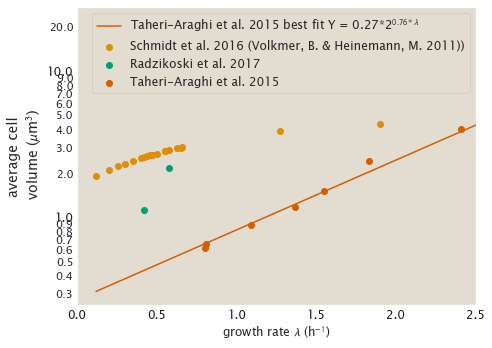

In [30]:
# set color for each dataset
pal = sns.color_palette(palette='colorblind', n_colors=8)
colorlist = pal.as_hex()
datasets_arr = np.append(combined_df.dataset.unique(), 
            ['Schmidt', 'Radzikoski', 'Taheri-Araghi'])
color_dict = dict(zip(datasets_arr, colorlist))

fig, ax = plt.subplots(1,1,figsize=(7,5))


###################
# Schmidt et al. 2015
combined_df = combined_df.sort_values('growth_rate_hr', ascending=False)
df_group = combined_df.groupby('condition', sort = False)

for cond, data in df_group:
    vol = df_grow[df_grow.condition==cond].volume_fL.values[0]
    ax.scatter(data.growth_rate_hr.unique()[0], vol,
               label ='Schmidt et al. 2016 (Volkmer, B. & Heinemann, M. 2011))',
              color = color_dict['Schmidt'])
    ax.set_ylabel('copy number of\nDNA-associated proteins', fontsize=14)

###################
# Radzikoski et al. 2017
vol_new = {'fumarate':1.11, 'glucose':2.15, 'stationary_1day':0.92}
for i, cond in enumerate(['fumarate','glucose']):
    growthrate =  combined_df[combined_df.condition==cond].growth_rate_hr.unique()[0]  
    
    ax.scatter(growthrate, vol_new[cond], color = color_dict['Radzikoski'],
                label='Radzikoski et al. 2017' )

###################
# Taheri-Araghi et al. 2015
# volumes from Taheri-Araghi, ..., Suckjoon Jun 2015
x_data = np.array([1.16, 1.17, 1.57, 1.97, 2.23, 2.64, 3.47])
y_data = np.array([0.61, 0.65, 0.87, 1.17, 1.50, 2.39, 3.95])
ax.scatter(x_data*np.log(2),y_data, label = 'Taheri-Araghi et al. 2015', color = color_dict['Taheri-Araghi'])

x = np.linspace(combined_df.growth_rate_hr.min(), 4, 100)
# y = 0.27*2**(1.10*x)
y = 0.27 * 2**(1.1  * x / np.log(2))
ax.plot(x,y, label = 'Taheri-Araghi et al. 2015 best fit Y = 0.27*2$^{0.76*\lambda}$',
       color = color_dict['Taheri-Araghi'])



ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set_ylabel('average cell\n volume ($\mu$m$^3$)')
ax.set_xlabel('growth rate $\lambda$ (h$^{-1}$)')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(False)
plt.tick_params(which='both', width=1)
plt.tick_params(which='both', length=12, color='white')
# plt.tick_params(axis='y', which='minor', labelsize=14)
ax.get_yaxis().set_tick_params(which='both', direction='in') 
ax.get_xaxis().set_tick_params(which='both', direction='in') 
ax.tick_params(axis='both', colors='white', labelcolor='k')

ax.set_yscale('log')

# Put a legend to the right of the current axis
lgd = ax.legend( loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, ncol=1)

from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=12)

ax.set_xlim(0,2.5)

plt.tight_layout()

## Schmidt copy number correction using Taheri-Araghi cell volumes

combined_df

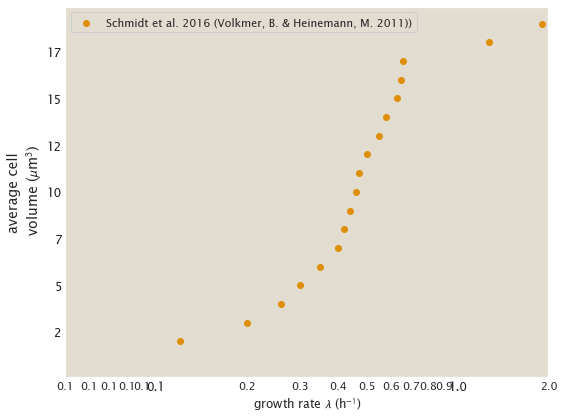

In [31]:
# set color for each dataset
pal = sns.color_palette(palette='colorblind', n_colors=8)
colorlist = pal.as_hex()
datasets_arr = np.append(combined_df.dataset.unique(), 
            ['Schmidt', 'Radzikoski', 'Taheri-Araghi'])
color_dict = dict(zip(datasets_arr, colorlist))

fig, ax = plt.subplots(1,1,figsize=(8,6))


###################
# Schmidt et al. 2015

ax.scatter(combined_df.sort_values(by='growth_rate_hr').growth_rate_hr.unique(),np.arange(20)[1:],
           label ='Schmidt et al. 2016 (Volkmer, B. & Heinemann, M. 2011))',
          color = color_dict['Schmidt'])
ax.set_ylabel('copy number of\nDNA-associated proteins', fontsize=14)



ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set_ylabel('average cell\n volume ($\mu$m$^3$)')
ax.set_xlabel('growth rate $\lambda$ (h$^{-1}$)')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(False)
plt.tick_params(which='both', width=1)
plt.tick_params(which='both', length=12, color='white')
# plt.tick_params(axis='y', which='minor', labelsize=14)
ax.get_yaxis().set_tick_params(which='both', direction='in') 
ax.get_xaxis().set_tick_params(which='both', direction='in') 
ax.tick_params(axis='both', colors='white', labelcolor='k')

# ax.set_yscale('log')
ax.set_xscale('log')

# Put a legend to the right of the current axis
lgd = ax.legend( loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, ncol=1)

from matplotlib.ticker import FormatStrFormatter
ax.xaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# ax.set_ylim(0.3,5)
ax.set_xlim(0.05,2)
plt.tight_layout()

In [33]:
# calculate total cell mass
combined_df.head()

for cond, data in combined_df.groupby(['condition']):
    data = data[['gene_name', 'growth_rate_hr', 'tot_per_cell', 'fg_per_cell']].drop_duplicates()
    print(cond, data.fg_per_cell.sum())

42C 8404.446194859021
acetate 6483.23864849472
chemostat_u0.12 5350.374073753501
chemostat_u0.2 5868.267014450121
chemostat_u0.35 6785.98837677978
chemostat_u0.5 7626.1277868468605
fructose 8374.4127735618
fumarate 7130.628316654201
galactose 6196.20948911346
glucosamine 7370.252413740081
glucose 8003.928084345362
glycerol 7394.056815779781
glycerol_pAA 10916.16261338106
lb_miller 12307.39007105742
mannose 7433.91287074304
osmotic_stress_glucose 7768.655868482421
pH6 8029.3614920046
pyruvate 7002.087671961121
stationary_1day 4356.732786598461
stationary_3day 4364.6033157972
succinate 7278.015305717001
xylose 7867.921139010141


In [74]:
combined_df2 = pd.read_csv('../../../data/schmidt2016_longform_annotated.csv')
combined_df2['fg_per_cell_'] = (combined_df2['tot_per_cell'] * combined_df2['mass_da'] * 1E15 ) / constants.Avogadro 
for cond, data in combined_df2.groupby(['condition']):
    data = data[['gene_name', 'growth_rate_hr', 'tot_per_cell', 'fg_per_cell_']].drop_duplicates()
    print(cond, data.fg_per_cell_.sum())

42C 231.74877523287915
acetate 178.77235233538445
chemostat_u0.12 147.53412775592446
chemostat_u0.2 161.8147896729003
chemostat_u0.35 187.12053817719132
chemostat_u0.5 210.2869996897914
fructose 230.92061732213645
fumarate 196.6238275207636
galactose 170.8576540196978
glucosamine 203.23135283872043
glucose 220.70467078886412
glycerol 203.88774838102592
glycerol_pAA 301.0082112776786
lb_miller 339.37067465855785
mannose 204.9867609404733
osmotic_stress_glucose 214.21714661315886
pH6 221.40598541904555
pyruvate 193.07937779919976
stationary_1day 120.13492190939755
stationary_3day 120.35194816668482
succinate 200.68795660299378
xylose 216.95434122831762


In [83]:
combined_df2[combined_df2.gene_name == 'zwf']

,annotation,cog_category,cog_class,cog_letter,condition,gene_name,growth_rate_hr,mass_da,tot_per_cell,fg_per_cell,dataset,strain,fg_per_cell_
35904,Glucose-6-phosphate 1-dehydrogenase,Metabolism,Carbohydrate transport and metabolism,G,lb_miller,zwf,1.90,55704.0,1508.0,0.139488,schmidt_2016,BW25153,0.139488
35905,Glucose-6-phosphate 1-dehydrogenase,Metabolism,Carbohydrate transport and metabolism,G,glycerol_pAA,zwf,1.27,55704.0,1154.0,0.106743,schmidt_2016,BW25153,0.106743
35906,Glucose-6-phosphate 1-dehydrogenase,Metabolism,Carbohydrate transport and metabolism,G,acetate,zwf,0.30,55704.0,625.0,0.057812,schmidt_2016,BW25153,0.057812
35907,Glucose-6-phosphate 1-dehydrogenase,Metabolism,Carbohydrate transport and metabolism,G,fumarate,zwf,0.42,55704.0,843.0,0.077976,schmidt_2016,BW25153,0.077976
35908,Glucose-6-phosphate 1-dehydrogenase,Metabolism,Carbohydrate transport and metabolism,G,galactose,zwf,0.26,55704.0,1198.0,0.110813,schmidt_2016,BW25153,0.110813
35909,Glucose-6-phosphate 1-dehydrogenase,Metabolism,Carbohydrate transport and metabolism,G,glucose,zwf,0.58,55704.0,1234.0,0.114143,schmidt_2016,BW25153,0.114143
35910,Glucose-6-phosphate 1-dehydrogenase,Metabolism,Carbohydrate transport and metabolism,G,glucosamine,zwf,0.46,55704.0,1117.0,0.103321,schmidt_2016,BW25153,0.103321
35911,Glucose-6-phosphate 1-dehydrogenase,Metabolism,Carbohydrate transport and metabolism,G,glycerol,zwf,0.47,55704.0,1171.0,0.108316,schmidt_2016,BW25153,0.108316
35912,Glucose-6-phosphate 1-dehydrogenase,Metabolism,Carbohydrate transport and metabolism,G,pyruvate,zwf,0.40,55704.0,998.0,0.092314,schmidt_2016,BW25153,0.092314
35913,Glucose-6-phosphate 1-dehydrogenase,Metabolism,Carbohydrate transport and metabolism,G,succinate,zwf,0.44,55704.0,871.0,0.080566,schmidt_2016,BW25153,0.080566


1426

In [3]:
combined_df3 = pd.read_csv('../../../data/schmidt2016_raw_data/schmidt2016_dataset.csv')

In [4]:
len(combined_df3.gene.unique())

2055

In [84]:
combined_df2 = pd.read_csv('../../../data/schmidt2016_longform_annotated.csv')

print(len(combined_df2.gene_name.unique()))

1426


In [85]:
cog_df = pd.read_csv('../../../data/escherichia_coli_gene_annotations.csv')

In [90]:
count = 0
for gene, data in cog_df.groupby('gene_name'):
    if gene in combined_df3.gene.unique():
        count += 1
        
print(count)

1426


In [5]:
len(combined_df3.uniprot.unique())

2057